Last 20 epochs of final model (already trained 30 epochs)

* Openpose (+gamma) without background and frame difference as input. Addition as combination

* preConvLSTM of 9 filters

* ConvLSTM of 32 filters

* DepthConv of 2 filters per channel

* 128-16-1 as final classifier

In [1]:
# Use output of OpenPose with or without background
BACKGROUND = False
# Paths to videos for training
# PATHS = ["../../../datasets/RWF-2000", f"../../../datasets/openpose_processed/gamma/{'' if BACKGROUND else 'no_'}back"]
path_original = "../../../RWF-2000/original_data"
path_openpose_gamma = "../../../RWF-2000/openpose_gamma"
PATHS = [path_original, path_openpose_gamma]
FRAME_FUNC = 'frame_diff'
# To use frame diff to weight t (current) or t+1
WEIGHT_CURRENT = True

In [2]:
import tensorflow as tf

2024-12-15 18:05:05.106061: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-15 18:05:05.113794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734257105.122519 2012759 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734257105.125324 2012759 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 18:05:05.135365: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import backend as K

# # Clear session
# K.clear_session()


# import gc
# # del model
# gc.collect()


In [3]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
print(os.environ.get('TF_FORCE_GPU_ALLOW_GROWTH'))  # Should print 'true'


true


In [4]:
import tensorflow as tf

# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    # Enable memory growth on the single GPU
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)  # Ensure incremental memory allocation
        print(f"Memory growth enabled for: {gpus[0]}")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")
else:
    print("No GPU detected.")


Memory growth enabled for: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Set seed

In [6]:
SEED = 0
import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data

In [7]:
import numpy as np
import cv2

DataGenerator class to load videos per batch, in case all videos do not fit in memory

## Videos to load

In [8]:
def get_slug_from_path(path):
    """
    Function to get slug from path
    slug must contain /train or /val because there are repeated names
    """
    # Try train index first
    index = path.rfind('/train/')
    if index == -1:
        index = path.rfind('/val/')
    return path[index:]


In [9]:
import cv2
from PIL import Image
from IPython.display import display, clear_output
import time
def display_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video was successfully opened
    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    # Display the video frames in Jupyter Notebook
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Convert the frame from BGR (OpenCV format) to RGB (Pillow format)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Convert the frame to a PIL Image
            frame_image = Image.fromarray(frame_rgb)

            # Display the frame in the notebook
            clear_output(wait=True)  # Clear the previous frame
            display(frame_image)

            # Adjust frame display time to match video frame rate (e.g., 30 fps = 1/30 ≈ 0.033 seconds)
            time.sleep(0.033)
    except KeyboardInterrupt:
        print("Stopped by user.")
    finally:
        # Release the video capture object
        cap.release()

In [10]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import cv2
import gc
# Constants
ORIGINAL_FRAMES_PER_VIDEO = 150
FRAMES_PER_VIDEO = 50 + 1
VIDEO_WIDTH, VIDEO_HEIGHT = 100, 100
N_CHANNELS = 3

# Function to load a single video
def load_single_video(video_ID, video_frames, video_width, video_height, video_channels, dtype, normalize, frames_idx):
    cap = cv2.VideoCapture(video_ID)
    frames = []
    index = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if index in frames_idx:
            frame = cv2.resize(frame, (video_width, video_height)).astype(dtype)
            if normalize:
                frame /= 255.0
            frames.append(frame)
        index += 1
    cap.release()
    return np.array(frames)

# Multithreaded video loading function
def load_videos_multithreaded(video_IDs, video_frames=FRAMES_PER_VIDEO, video_width=VIDEO_WIDTH,
                              video_height=VIDEO_HEIGHT, video_channels=N_CHANNELS,
                              dtype=np.float32, normalize=False) -> np.ndarray:
    frames_idx = set(np.round(np.linspace(0, ORIGINAL_FRAMES_PER_VIDEO - 1, video_frames)).astype(int))
    videos = np.empty((len(video_IDs), video_frames, video_height, video_width, video_channels), dtype=dtype)
    
    # Multithreading
    with ThreadPoolExecutor() as executor:
        results = executor.map(
            lambda video_ID: load_single_video(video_ID, video_frames, video_width,
                                               video_height, video_channels, dtype, normalize, frames_idx),
            video_IDs
        )
        
    for i, frames in enumerate(results):
        if frames.shape[0] < video_frames:  # Padding if video has fewer frames
            pad_frames = np.zeros((video_frames - frames.shape[0], video_height, video_width, video_channels), dtype=dtype)
            frames = np.concatenate((frames, pad_frames), axis=0)
        videos[i] = frames

    return videos

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_IDs: list, video_labels: dict, batch_size: int, paths: list = [''], video_width: int = VIDEO_WIDTH,
                 video_height: int = VIDEO_HEIGHT, video_frames: int = FRAMES_PER_VIDEO, video_channels: int = N_CHANNELS,
                 dtype=np.float32, normalize: bool = False, shuffle: bool = True):
        self.video_IDs = video_IDs
        self.video_labels = video_labels
        self.batch_size = batch_size
        self.paths = paths
        self.video_width = video_width
        self.video_height = video_height
        self.video_frames = video_frames
        self.video_channels = video_channels
        self.dtype = dtype
        self.normalize = normalize
        self.shuffle = shuffle

    def __len__(self):
        return len(self.video_IDs) // self.batch_size

    def __getitem__(self, idx):
        batch_IDs = self.video_IDs[idx * self.batch_size:(idx + 1) * self.batch_size]
        input_videos = []
        
        for path in self.paths:
            batch_IDs_full_path = [path + ID for ID in batch_IDs]
            # Use multithreaded loading here
            videos = load_videos_multithreaded(batch_IDs_full_path, self.video_frames, self.video_width, 
                                               self.video_height, self.video_channels, self.dtype, self.normalize)
            input_videos.append(videos)
        
        labels = np.array([self.video_labels[ID] for ID in batch_IDs])
                    
        return tuple(input_videos), labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.video_IDs)
        gc.collect()


In [11]:
import glob

train_video_IDs = [get_slug_from_path(path) for path in glob.glob(PATHS[0]+'/train/*/*')]
test_video_IDs = [get_slug_from_path(path) for path in glob.glob(PATHS[0]+'/val/*/*')]

train_video_labels = {video: 0 if 'NonFight' in video else 1 for video in train_video_IDs}
test_video_labels = {video: 0 if 'NonFight' in video else 1 for video in test_video_IDs}

# Define train and test generators
train_generator = DataGenerator(train_video_IDs, train_video_labels, batch_size=10, paths=PATHS)
test_generator = DataGenerator(test_video_IDs, test_video_labels, batch_size=10, paths=PATHS)

# Example: Fetch a batch of videos and labels
batch_videos, batch_labels = train_generator[0]
print(f"Batch videos shape: {np.array(batch_videos).shape}")
print(f"Batch labels shape: {batch_labels.shape}")


Batch videos shape: (2, 10, 51, 100, 100, 3)
Batch labels shape: (10,)


# Frame functions

In [14]:
import tensorflow.keras.backend as K

def tf_frame_diff(video):
    return video[1:] - video[:-1]

def tf_frame_dist(video):
    video_diff = tf_frame_diff(video)
    return K.sqrt(K.sum(K.square(video_diff), axis=-1, keepdims=True))

if WEIGHT_CURRENT:
    def tf_frame_diff_dist_combined(video):
        video_diff = tf_frame_diff(video)
        video_diff_current = tf.nn.relu(-video_diff)
        video_diff_next = tf.nn.relu(video_diff)
        video_diff_next_norm = K.sqrt(K.sum(K.square(video_diff_next), axis=-1, keepdims=True))
        return K.concatenate([video_diff_current, video_diff_next_norm])
else:
    def tf_frame_diff_dist_combined(video):
        video_diff = tf_frame_diff(video)
        video_diff_current = tf.nn.relu(video_diff)
        video_diff_prev = tf.nn.relu(-video_diff)
        video_diff_prev_norm = K.sqrt(K.sum(K.square(video_diff_prev), axis=-1, keepdims=True))
        return K.concatenate([video_diff_current, video_diff_prev_norm])
    
frame_func_dict = {'frame_diff': tf_frame_diff, 'frame_dist': tf_frame_dist, 'frame_diff_dist_combined': tf_frame_diff_dist_combined}
frame_func = frame_func_dict[FRAME_FUNC]

# ConvLSTM

In [15]:
inputs_raw = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))
inputs_openpose = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))

inputs_diff = tf.keras.layers.Lambda(lambda video: tf.map_fn(frame_func, video))(inputs_raw)
inputs_to_weight = inputs_openpose[:, :-1] if WEIGHT_CURRENT else inputs_openpose[:, 1:]

inputs_diff_norm = tf.keras.layers.BatchNormalization()(inputs_diff)
inputs_diff_time_info_weight = tf.keras.layers.ConvLSTM2D(filters=9, kernel_size=(3, 3), return_sequences=True, data_format='channels_last', activation='tanh')(inputs_diff_norm)

convolutional_layer = tf.keras.layers.Conv2D(filters=9, kernel_size=(3,3), activation='relu')
inputs_openpose_soft = tf.keras.layers.TimeDistributed(convolutional_layer)(inputs_to_weight)

inputs_openpose_norm = tf.keras.layers.BatchNormalization(scale=False, center=False)(inputs_openpose_soft)

inputs_weighted = tf.keras.layers.Add()([inputs_openpose_norm, inputs_diff_time_info_weight])

x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=False, data_format='channels_last', activation='tanh')(inputs_weighted)

x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), depth_multiplier=2, activation='relu', data_format='channels_last')(x)

x = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x)

x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dense(units=16, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

model = tf.keras.Model([inputs_raw, inputs_openpose], outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

I0000 00:00:1734256639.591146 2012283 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13224 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 51, 100,   │          0 │ -                 │
│ (InputLayer)        │ 100, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 51, 100,   │          0 │ -                 │
│ (InputLayer)        │ 100, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 50, 100,   │          0 │ input_layer_1[0]… │
│                     │ 100, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 50, 100,   │          0 │ input_layer[0][0] │
│                     │ 100, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 50, 98,    │        252 │ get_item[0][0]    │
│ (TimeDistributed)   │ 98, 9)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 100,   │         12 │ lambda[0][0]      │
│ (BatchNormalizatio… │ 100, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 98,    │         18 │ time_distributed… │
│ (BatchNormalizatio… │ 98, 9)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 50, 98,    │      3,924 │ batch_normalizat… │
│ (ConvLSTM2D)        │ 98, 9)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 98,    │          0 │ batch_normalizat… │
│                     │ 98, 9)            │            │ conv_lstm2d[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 96, 96,    │     47,360 │ add[0][0]         │
│ (ConvLSTM2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 94, 94,    │        640 │ conv_lstm2d_1[0]… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ depthwise_conv2d… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      2,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         17 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,607 (244.56 KB)

 Trainable params: 62,583 (244.46 KB)

 Non-trainable params: 24 (96.00 B)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Constants
FRAMES_PER_VIDEO = 51
VIDEO_HEIGHT = 100
VIDEO_WIDTH = 100
N_CHANNELS = 3
WEIGHT_CURRENT = True  # Example boolean flag
FRAME_FUNC = 'frame_diff_dist_combined'  # Choose from 'frame_diff', 'frame_dist', 'frame_diff_dist_combined'

# Frame Function Dictionary
frame_func_dict = {
    'frame_diff': lambda video: video[1:] - video[:-1],
    'frame_dist': lambda video: tf.sqrt(tf.reduce_sum(tf.square(video[1:] - video[:-1]), axis=-1, keepdims=True)),
    'frame_diff_dist_combined': lambda video: tf.concat(
        [tf.nn.relu(video[1:] - video[:-1]), tf.sqrt(tf.reduce_sum(tf.square(video[1:] - video[:-1]), axis=-1, keepdims=True))],
        axis=-1,
    ),
}

@tf.keras.utils.register_keras_serializable(package="Custom", name="FrameProcessingLayer")
class FrameProcessingLayer(layers.Layer):
    def __init__(self, func_name, **kwargs):
        super(FrameProcessingLayer, self).__init__(**kwargs)
        self.func_name = func_name
        self.func = frame_func_dict[func_name]

    def call(self, video):
        return tf.map_fn(self.func, video)

    def get_config(self):
        config = super(FrameProcessingLayer, self).get_config()
        config.update({"func_name": self.func_name})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

@tf.keras.utils.register_keras_serializable(package="Custom", name="SliceLayer")
class SliceLayer(layers.Layer):
    def __init__(self, weight_current, **kwargs):
        super(SliceLayer, self).__init__(**kwargs)
        self.weight_current = weight_current

    def call(self, inputs):
        return inputs[:, :-1] if self.weight_current else inputs[:, 1:]

    def get_config(self):
        config = super(SliceLayer, self).get_config()
        config.update({"weight_current": self.weight_current})
        return config

# Inputs
inputs_raw = layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))
inputs_openpose = layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))

# Frame Processing
inputs_diff = FrameProcessingLayer(FRAME_FUNC)(inputs_raw)

# Replace slicing with SliceLayer
inputs_to_weight = SliceLayer(WEIGHT_CURRENT)(inputs_openpose)

# Model Layers
inputs_diff_norm = layers.BatchNormalization()(inputs_diff)
inputs_diff_time_info_weight = layers.ConvLSTM2D(
    filters=9, kernel_size=(3, 3), return_sequences=True, activation='tanh'
)(inputs_diff_norm)

convolutional_layer = layers.Conv2D(filters=9, kernel_size=(3, 3), activation='relu')
inputs_openpose_soft = layers.TimeDistributed(convolutional_layer)(inputs_to_weight)

inputs_openpose_norm = layers.BatchNormalization(scale=False, center=False)(inputs_openpose_soft)

inputs_weighted = layers.Add()([inputs_openpose_norm, inputs_diff_time_info_weight])

x = layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=False, activation='tanh')(inputs_weighted)
x = layers.DepthwiseConv2D(kernel_size=(3, 3), depth_multiplier=2, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(units=128, activation='relu')(x)
x = layers.Dense(units=16, activation='relu')(x)
outputs = layers.Dense(units=1, activation='sigmoid')(x)

# Model
model = Model([inputs_raw, inputs_openpose], outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Save Model
# model.save('test.keras')

# # Load Model
# loaded_model = tf.keras.models.load_model('test.keras')

# Verify Model
model.summary()


I0000 00:00:1734258002.680032 2022203 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22211 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 51, 100,   │          0 │ -                 │
│ (InputLayer)        │ 100, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 51, 100,   │          0 │ -                 │
│ (InputLayer)        │ 100, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer         │ (None, 50, 100,   │          0 │ input_layer_1[0]… │
│ (SliceLayer)        │ 100, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frame_processing_l… │ (None, 50, 100,   │          0 │ input_layer[0][0] │
│ (FrameProcessingLa… │ 100, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 50, 98,    │        252 │ slice_layer[0][0] │
│ (TimeDistributed)   │ 98, 9)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 100,   │         16 │ frame_processing… │
│ (BatchNormalizatio… │ 100, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 98,    │         18 │ time_distributed… │
│ (BatchNormalizatio… │ 98, 9)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 50, 98,    │      4,248 │ batch_normalizat… │
│ (ConvLSTM2D)        │ 98, 9)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 98,    │          0 │ batch_normalizat… │
│                     │ 98, 9)            │            │ conv_lstm2d[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 96, 96,    │     47,360 │ add[0][0]         │
│ (ConvLSTM2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 94, 94,    │        640 │ conv_lstm2d_1[0]… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ depthwise_conv2d… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      2,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         17 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,935 (245.84 KB)

 Trainable params: 62,909 (245.74 KB)

 Non-trainable params: 26 (104.00 B)

# Load pretrained best model to continue training

In [13]:
# Load Model
# model = tf.keras.models.load_model('best_model_no_bg.keras')

In [14]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'best_model_no_bg.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [15]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [16]:
import tensorflow as tf

# List physical devices
print("Physical Devices:", tf.config.list_physical_devices())
# Enable GPU logging
tf.debugging.set_log_device_placement(True)

# Perform a test operation
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)
    print(c)


Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [17]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, epochs=20, validation_data=test_generator, verbose=2, callbacks=[model_checkpoint_callback])

/home/wins054/anaconda3/envs/violence-detection-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1734258032.516334 2022300 service.cc:148] XLA service 0x7c90e0001a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734258032.516364 2022300 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-12-15 18:20:32.602316: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734258033.225755 2022300 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1734258038.502965 2022300 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 - 126s - 801ms/step - accuracy: 0.7618 - loss: 0.4902 - val_accuracy: 0.8250 - val_loss: 0.4477
Epoch 2/20
157/157 - 116s - 741ms/step - accuracy: 0.7917 - loss: 0.4522 - val_accuracy: 0.8300 - val_loss: 0.3885
Epoch 3/20
157/157 - 117s - 742ms/step - accuracy: 0.8197 - loss: 0.4180 - val_accuracy: 0.8525 - val_loss: 0.3479
Epoch 4/20
157/157 - 115s - 734ms/step - accuracy: 0.8331 - loss: 0.3912 - val_accuracy: 0.8625 - val_loss: 0.3473
Epoch 5/20
157/157 - 116s - 737ms/step - accuracy: 0.8414 - loss: 0.3772 - val_accuracy: 0.8600 - val_loss: 0.3377
Epoch 6/20
157/157 - 117s - 744ms/step - accuracy: 0.8471 - loss: 0.3715 - val_accuracy: 0.8500 - val_loss: 0.3660
Epoch 7/20
157/157 - 117s - 744ms/step - accuracy: 0.8548 - loss: 0.3526 - val_accuracy: 0.8700 - val_loss: 0.3470
Epoch 8/20
157/157 - 118s - 749ms/step - accuracy: 0.8510 - loss: 0.3603 - val_accuracy: 0.8475 - val_loss: 0.3713
Epoch 9/20
157/157 - 116s - 736ms/step - accuracy: 0.8643 - loss: 0.3401 - val_accuracy: 0.

In [ ]:
# model =  tf.keras.models.load_model('best_model_no_bg.keras',safe_mode=False)

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, epochs=30, validation_data=test_generator, verbose=2, callbacks=[model_checkpoint_callback])

Epoch 1/30
157/157 - 119s - 759ms/step - accuracy: 0.9013 - loss: 0.2737 - val_accuracy: 0.8725 - val_loss: 0.3635
Epoch 2/30
157/157 - 116s - 742ms/step - accuracy: 0.8917 - loss: 0.2767 - val_accuracy: 0.8575 - val_loss: 0.3826
Epoch 3/30
157/157 - 117s - 742ms/step - accuracy: 0.8975 - loss: 0.2654 - val_accuracy: 0.8275 - val_loss: 0.4624
Epoch 4/30
157/157 - 116s - 740ms/step - accuracy: 0.9057 - loss: 0.2523 - val_accuracy: 0.8675 - val_loss: 0.3683
Epoch 5/30
157/157 - 116s - 742ms/step - accuracy: 0.8631 - loss: 0.3434 - val_accuracy: 0.8700 - val_loss: 0.3360
Epoch 6/30
157/157 - 116s - 739ms/step - accuracy: 0.8943 - loss: 0.2735 - val_accuracy: 0.8050 - val_loss: 0.5233
Epoch 7/30
157/157 - 117s - 747ms/step - accuracy: 0.8917 - loss: 0.2794 - val_accuracy: 0.8650 - val_loss: 0.3667
Epoch 8/30
157/157 - 116s - 740ms/step - accuracy: 0.9032 - loss: 0.2651 - val_accuracy: 0.8650 - val_loss: 0.3596
Epoch 9/30
157/157 - 116s - 738ms/step - accuracy: 0.9038 - loss: 0.2588 - val_a

# Authors' Model performance

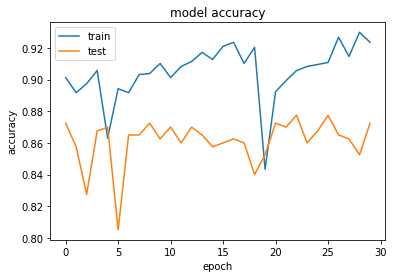

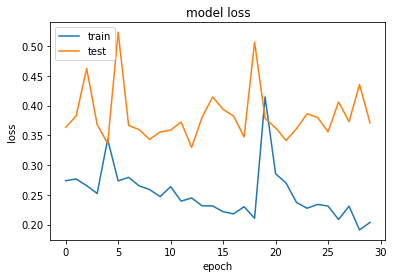

In [27]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Reproduce Model Performance

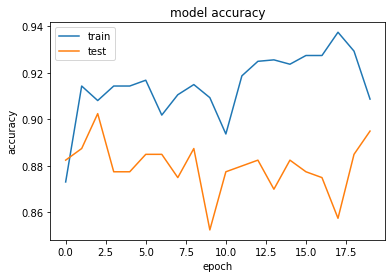

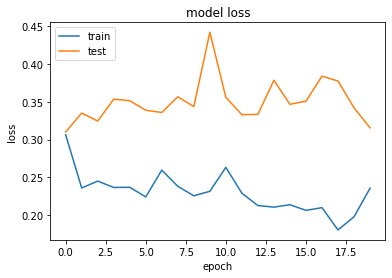

In [15]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save perfomance metrics

In [33]:
import os
import ipynbname
import json
# from keras.utils.layer_utils import count_params

current_directory = os.getcwd() + '/'
results_directory = current_directory.replace('notebooks', 'results_summary')

experiment_name = 'best_model_final_training'

# Save history as json
with open(results_directory + experiment_name + '.json', 'w') as f:
    json.dump(history.history, f)
    
# Compute max val_accuracy and number of trainable params and append to stats
max_val_acc = max(history.history['val_accuracy'])
trainable_params = model.count_params()

# Store value in latex table format
acc_string = f'{experiment_name} & {max_val_acc:.2%}'.replace('%', '\%')
acc_params_string = acc_string + f' & {trainable_params}'

with open(results_directory + 'acc.dat', 'a') as f:
    f.write(acc_string + ' \\\ \n')
    
with open(results_directory + 'acc_params.dat', 'a') as f:
    f.write(acc_params_string + ' \\\ \n')

In [25]:
model.save(f"{experiment_name}.keras")

In [ ]:
loaded_model =  tf.keras.models.load_model('best_model_no_bg.keras',safe_mode=False)

In [27]:
import tensorflow as tf
import keras

print (tf.__version__) # 2.18.0
print (keras.__version__) # 3.7.0

2.18.0
3.7.0


In [32]:
val_loss, val_acc = model.evaluate(test_generator, verbose=2)
print(f'Validation loss: {val_loss:.4f}\tValidation accuracy: {val_acc:.4f}')

40/40 - 25s - 614ms/step - accuracy: 0.8550 - loss: 0.4249
Validation loss: 0.4249	Validation accuracy: 0.8550


In [30]:
# model.save('best_model_no_bg_50epoch.keras')